### Importar bibliotecas

In [399]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


### Importar e visualizar as primeiras informações da base

In [400]:
base = pd.read_csv('diabetes.csv')

In [401]:
display(base)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [402]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Visualizar algumas informações estatísticas / análise exploratória

In [403]:
#informações estatísticas em geral
base.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


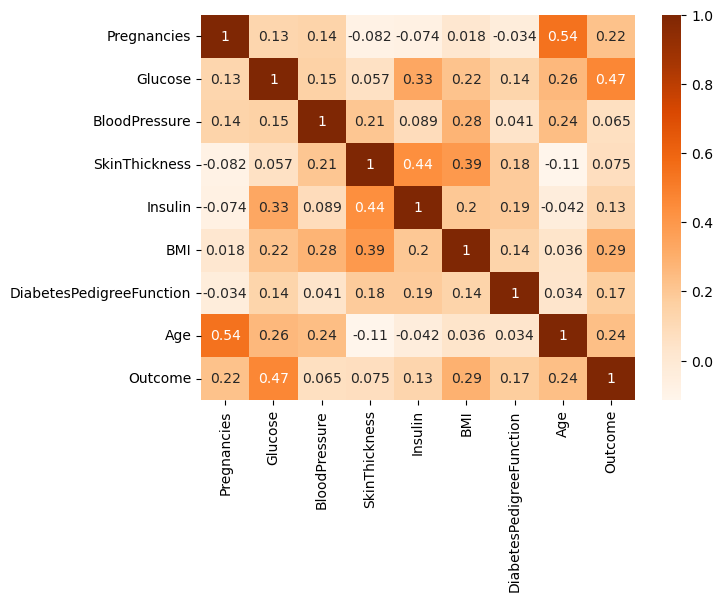

In [404]:
#correlação entre as variáveis
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(base.corr(), cmap = 'Oranges', annot = True)
plt.show()

A partir dessas informações iniciais, é possível realizar algumas observações sobre a base estudada:
- A maioria das mulheres possuem entre 21 e 41 anos
- Uma quantidade maior de pessoas do estudo não apresentam diabetes
- As maiores correlações com o resultado de positivo ou negativo para diabetes estão nas features: Glucose, BMI e Age. Porém, essa correlação um pouco mais forte não significa que alguma dessas features é a causa direta de diabetes, apenas significa que elas são correlacionadas.


#### Pregnancies

Fiquei ligeiramente intrigado com o valor máximo de 17 para a feature pregnancies, logo, optei por verificar melhor essa categoria para entender como esses dados estão distribuídos.

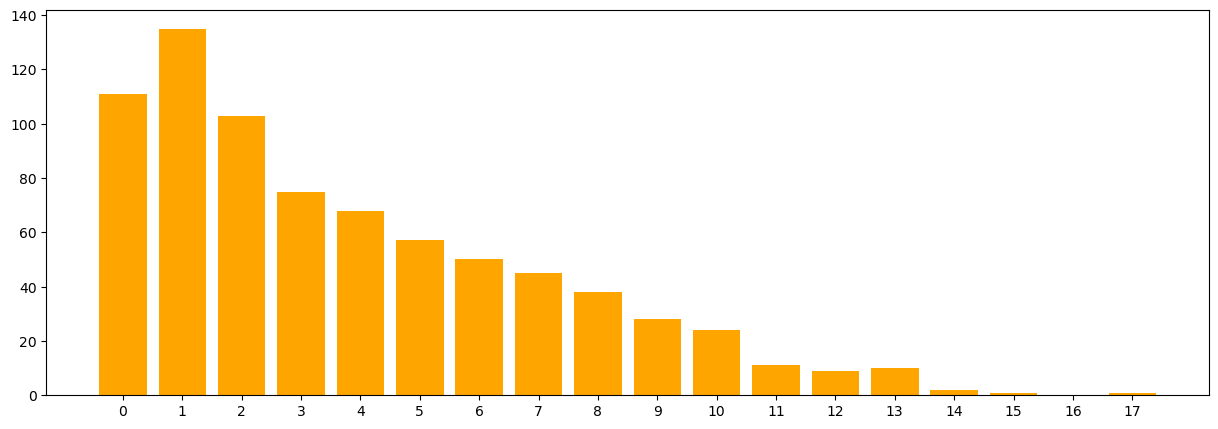

In [405]:
#contando os valores
preg = base['Pregnancies'].value_counts().reset_index()
preg.columns = ['Pregnancies', 'Quantidade']
preg = preg.sort_values('Pregnancies')

#criando um gráfico de barras
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(preg.Pregnancies, preg.Quantidade, color = 'Orange')
ax.set_xticks(np.arange(0,18))
plt.show()

Nota-se que de fato existe uma grande concentração de quantidade de gravidez abaixo de 6 (que seriam 75% dos dados), porém, existem sim em menor quantidade pessoas que engravidaram mais vezes. Talvez, essas sejam as pessoas de mais idade no grupo.
Vamos então verificar.


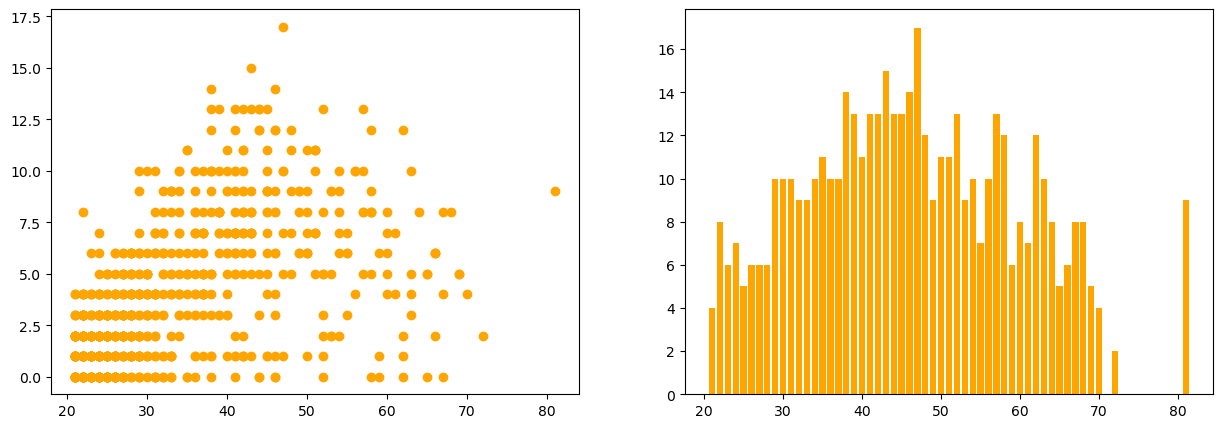

In [406]:
#grafico cruzando as idades com quantidade de gravidez para verificar visualmente a correlação
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].scatter(base.Age, base.Pregnancies, color = 'Orange')
ax[1].bar(base.Age, base.Pregnancies, color = 'Orange')
plt.show()


Através dos 2 gráficos foi possível observar que na verdade a quantidade de gravidez por pessoa está bastante distribuída, com as mulheres que possuem entre uns 38 e 55 anos apresentando em média os maiores valores.

### Tratar dados

Através da descrição dos dados, foi possível observar que algumas features (Glucose, BloodPressure, SkinThickness, Insulin e BMI) possuem valores igual a zero. Porém, qualquer pessoa deveria possuir algum valor diferente de zero associado a essas features.
Sendo assim, irei considerar que as pessoas que apresentam valores zerados é porque não foi possível coletar esses dados.

Para realizar o tratamento, irei substituir o valor zerado pela média daquela feature.

#### Criando algumas funções para agilizar o tratamento dos dados

In [407]:
#verificar quantas linhas possuem o valor zero para aquela coluna
def verificarzero(base, coluna):
    quantidade = base.loc[base[coluna] == 0, coluna].count()
    print (f'{quantidade} linhas com valores zerados')

# trocar o zero pela média
def trocarzero(base, coluna):
    base.loc[base[coluna] == 0, coluna] = np.nan
    media = base[coluna].mean()
    base.loc[base[coluna].isnull(), coluna] = media
    

    

#### Glucose

In [408]:
verificarzero(base, 'Glucose')

5 linhas com valores zerados


In [409]:
trocarzero(base, 'Glucose')
verificarzero(base, 'Glucose')

0 linhas com valores zerados


#### BloodPressure

In [410]:
verificarzero(base, 'BloodPressure')

35 linhas com valores zerados


In [411]:
trocarzero(base, 'BloodPressure')
verificarzero(base, 'BloodPressure')

0 linhas com valores zerados


Para as features SkinThickness e Insulin, antes de substituir os zeros, vou excluir as linhas que apresentam valores muitos extremos e estão deslocando a média muito para cima.

#### SkinThickness

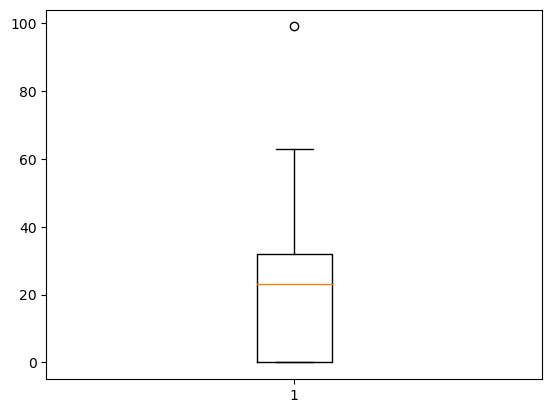

In [412]:
#boxplot para ver esses valores muito extremos
fig, ax = plt.subplots()
ax.boxplot(base.SkinThickness)
plt.show()

In [413]:
#excluir esses dados
base = base.loc[base.SkinThickness < 60]

In [414]:
verificarzero(base, 'SkinThickness')

227 linhas com valores zerados


In [415]:
trocarzero(base, 'SkinThickness')
verificarzero(base, 'SkinThickness')

0 linhas com valores zerados


#### Insulin

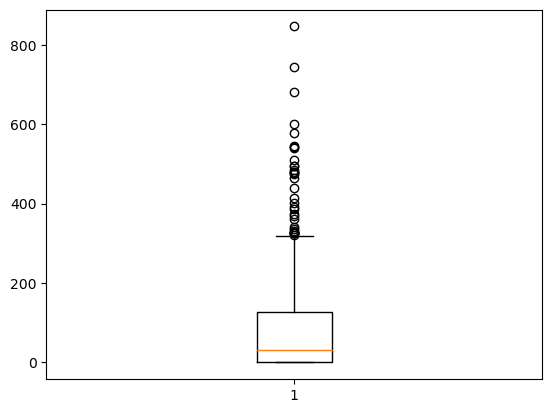

In [416]:
#boxplot para ver esses valores muito extremos
fig, ax = plt.subplots()
ax.boxplot(base.Insulin)
plt.show()

In [417]:
#excluir esses dados
base = base.loc[base.Insulin < 550]

In [418]:
verificarzero(base, 'Insulin')

373 linhas com valores zerados


In [419]:
trocarzero(base, 'Insulin')
verificarzero(base, 'Insulin')

0 linhas com valores zerados


#### BMI

In [420]:
verificarzero(base, 'BMI')

11 linhas com valores zerados


In [421]:
trocarzero(base, 'BMI')
verificarzero(base, 'BMI')

0 linhas com valores zerados


### Verificar novamente as informações estatísticas

In [422]:
base.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.864474,121.225571,72.377870,28.872447,149.129199,32.362083,0.465659,33.181579,0.346053
std,3.371398,30.067725,12.117466,8.251862,72.879542,6.769363,0.317619,11.706948,0.476023
min,0.000000,44.000000,24.000000,7.000000,15.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,25.000000,121.500000,27.500000,0.240750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,28.903346,149.129199,32.362083,0.368000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,149.129199,36.500000,0.616000,41.000000,1.000000
max,17.000000,199.000000,122.000000,56.000000,545.000000,67.100000,2.288000,81.000000,1.000000


### Aplicação dos modelos de Machine Learning


Para esse projeto, resolvi testar esses 3 modelos de classificação:
- Perceptron
- SVC
- DecisionTreeClassifier

#### Separar a base

In [423]:
#Separando em X e y

X = base.drop('Outcome', axis = 1)
y = base.Outcome

#Separando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

#### Perceptron

In [424]:
#treinar
percep = Perceptron()
percep.fit(X_train, y_train)

Perceptron()

Acurácia: 62.63%


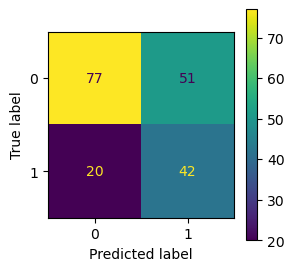

In [425]:
#testar
fig, ax = plt.subplots(figsize = (3,3))
percep_predict = percep.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, percep_predict, ax = ax)
print (f'Acurácia: {accuracy_score(y_test, percep_predict):.2%}')


#### Decision Treee

In [426]:
#treinar
modeltree =  tree.DecisionTreeClassifier()
modeltree.fit(X_train, y_train)

DecisionTreeClassifier()

Acurácia: 73.16%


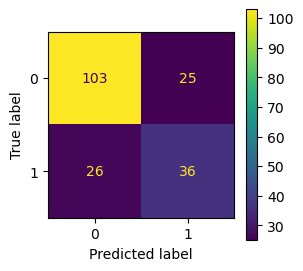

In [427]:
#testar
fig, ax = plt.subplots(figsize = (3,3))
tree_predict = modeltree.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, tree_predict, ax = ax)
print (f'Acurácia: {accuracy_score(y_test, tree_predict):.2%}')

#### SVC

In [428]:
#treinar

modelsvc = SVC()
modelsvc.fit(X_train, y_train)

SVC()

Acurácia: 78.42%


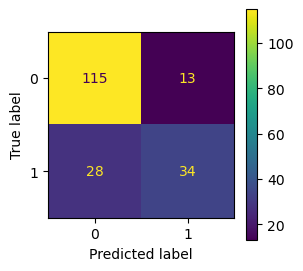

In [429]:
#testar
fig, ax = plt.subplots(figsize = (3,3))
svc_predict = modelsvc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svc_predict, ax = ax)
print (f'Acurácia: {accuracy_score(y_test, svc_predict):.2%}')


Com os 3 modelos testados, pode-se tirar as seguintes conclusões:
- Olhando somente a acurácia, o modelo SVC mostrou-se um pouco melhor que o modelo de DecisionTreee, com acuárias de 78,42% e 73,16% respectivamente.
- O modelo SVC apresenta poucos resultados falsos positivos, porém, apresenta muitos resultados falsos negativos.
- O Perceptron foi o modelo que apresentou menor quantidade de resultados falsos negativos, porém, foi o que mais errou no parâmetro falso positivo.